# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D , Dropout , BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
#Extract the training and testing images each into 2 seperate variable
train_inputs , train_labels , test_inputs , test_labels = train['X'],train['y'],test['X'],test['y']

In [4]:
# inspect the shape
print(f'train_inputs: {train_inputs.shape}')
print(f'train_labels: {train_labels.shape}')
print(f'test_inputs: {test_inputs.shape}')
print(f'test_labels: {test_labels.shape}')

train_inputs: (32, 32, 3, 73257)
train_labels: (73257, 1)
test_inputs: (32, 32, 3, 26032)
test_labels: (26032, 1)


In [5]:
# reshape to dimension (num_sample , width , height , channel)
# RUN THIS CELL 1-time ONLY!
permutaion = [3,0,1,2]
train_inputs = np.transpose(train_inputs, axes = permutaion)
test_inputs = np.transpose(test_inputs, axes = permutaion)
print(f'train_inputs: {train_inputs.shape}')
print(f'train_labels: {train_labels.shape}')
print(f'test_inputs: {test_inputs.shape}')
print(f'test_labels: {test_labels.shape}')

train_inputs: (73257, 32, 32, 3)
train_labels: (73257, 1)
test_inputs: (26032, 32, 32, 3)
test_labels: (26032, 1)


In [6]:
# Note : SVGN Dataset label into 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.

# To use with sparse_categorical_crossentropy with 10 output categories. label must be 0-9

# remove dimension == 1
train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

# dight '0' has label 10 >> change to label 0

# create list of index of label 10
index_zero_train_labels = np.where(train_labels== 10)[0]
index_zero_test_labels = np.where(test_labels == 10)[0]

# get 1 index and check that it label as 10
sample_index_train = index_zero_train_labels[0]
sample_index_test = index_zero_test_labels[0]
print(f'Train sample index {sample_index_train} has label {train_labels[sample_index_train]}')
print(f'Test sample index {sample_index_test} has label {test_labels[sample_index_test]}')

# change label 10 to label 0 for digit '0'
train_labels[index_zero_train_labels] = 0
test_labels[index_zero_test_labels] = 0

# check index and label again
print(f'Train sample index {sample_index_train} has label {train_labels[sample_index_train]}')
print(f'Test sample index {sample_index_test} has label {test_labels[sample_index_test]}')

Train sample index 52 has label 10
Test sample index 3 has label 10
Train sample index 52 has label 0
Test sample index 3 has label 0


In [7]:
#Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
def plot_10_random_sample(inputarr,labelarr,colormap ='viridis'):
    rand_10_sample = np.random.permutation(inputarr.shape[0])[:10] # Randomly permute a sequence in range of number example and pick 10 example

    # create figure
    fig = plt.figure(figsize=(8, 8))
    # set row,column
    rows = 2
    columns = 5
    
    for i,sample in enumerate(rand_10_sample):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(inputarr[sample],cmap=colormap)
        plt.title(f'Label: {labelarr[sample]}')
        

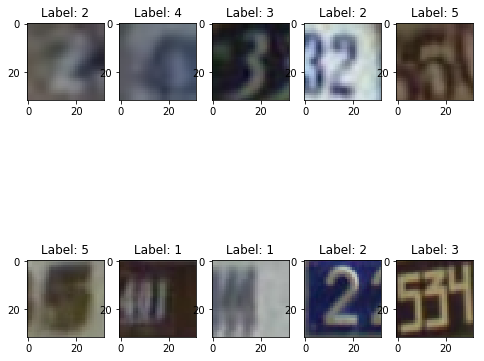

In [8]:
# plot 10 sample
plot_10_random_sample(train_inputs,train_labels)

In [9]:
#Convert the training and test images to grayscale by taking the average across all colour channels for each pixel
# -1 = average across color channel (last dimension)
train_inputs = np.mean(train_inputs, axis = -1,keepdims=True)
test_inputs = np.mean(test_inputs, axis = -1,keepdims=True)

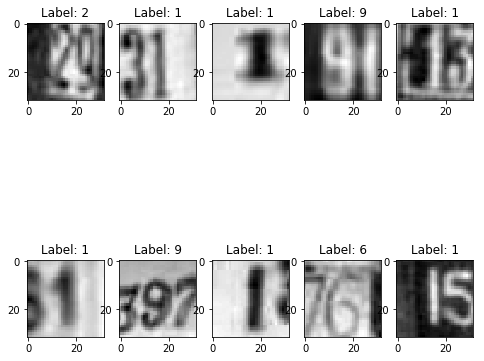

In [10]:
# plot 10 sample (grayscale)

#Note: matplotlib.pyplot.imshow() needs a 2D array (grayscale), or a 3D array with the third dimension being of shape 3 or 4!
plot_10_random_sample(np.squeeze(train_inputs),np.squeeze(train_labels),colormap='gray')

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [11]:
# Create model
def get_MLP_model(input_shape):
    model = Sequential([
        Flatten(input_shape = input_shape),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(10,activation='softmax')
    ]
    )
    
    # define optimizer , loss function , and evaluation metric
    opt =  tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    acc = tf.keras.metrics.SparseCategoricalAccuracy()
    
    model.compile(optimizer  = opt , loss = loss,metrics=[acc])
    
    return model
    

In [12]:
# get new model and print summary
model = get_MLP_model(train_inputs[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 182,026
Trainable params: 182,026
Non-trainable params: 0
__________________________________________________

In [13]:
# define training function
def train_model(model, train_data, train_targets, epochs ,callbacks=None):
    if callbacks != None:
        history = model.fit(train_data,train_targets , epochs = epochs ,validation_split  = 0.15 , batch_size = 64,callbacks = callbacks)
    else:
        history = model.fit(train_data,train_targets , epochs = epochs ,validation_split  = 0.15 , batch_size = 64)
    
    return history
    

In [14]:
# MLP_Callback 

def MLP_model_checkpoint_best():
    checkpoint_path = 'MLP_checkpoints_best_only/checkpoint'
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                save_weights_only = True,
                                save_freq  = 'epoch',
                                save_best_only = True,
                                monitor = 'val_sparse_categorical_accuracy'
                                )
    return checkpoint


def MLP_model_checkpoint_every_epoch():
    checkpoint_path = 'MLP_checkpoints_every_epoch/checkpoint_{epoch:03d}' 
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                save_weights_only = True,
                                save_freq  = 'epoch'
                                )
    return checkpoint

def early_stopping():
    
    callback = EarlyStopping(monitor='val_loss', patience=3)
    
    return callback
    
def custom_callbacks():
    
    #aim for categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
    
    class CustomCallback(Callback):
        def on_epoch_end(self, epoch, logs=None):
            loss = logs['val_loss']
            if (loss < 1.0):
                print('Validation loss less than 1. Stop training')
                self.model.stop_training = True
                
                
    callback = CustomCallback()
    
    return callback
    


In [15]:
# Create Callback object

callbacks = [MLP_model_checkpoint_best(),MLP_model_checkpoint_every_epoch(),custom_callbacks()]

In [16]:
# Train model
history = train_model(model, train_inputs, train_labels, epochs=30,callbacks = callbacks)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62268/62268 [==============================] - 31s 493us/sample - loss: 3.3464 - sparse_categorical_accuracy: 0.3186 - val_loss: 1.5748 - val_sparse_categorical_accuracy: 0.4883
Epoch 2/30
62268/62268 [==============================] - 29s 461us/sample - loss: 1.4718 - sparse_categorical_accuracy: 0.5198 - val_loss: 1.3741 - val_sparse_categorical_accuracy: 0.5478
Epoch 3/30
62268/62268 [==============================] - 29s 459us/sample - loss: 1.3035 - sparse_categorical_accuracy: 0.5847 - val_loss: 1.2469 - val_sparse_categorical_accuracy: 0.6089
Epoch 4/30
62268/62268 [==============================] - 29s 464us/sample - loss: 1.2335 - sparse_categorical_accuracy: 0.6116 - val_loss: 1.1895 - val_sparse_categorical_accuracy: 0.6158
Epoch 5/30
62268/62268 [==============================] - 29s 462us/sample - loss: 1.1826 - sparse_categorical_accuracy: 0.6282 - val_loss: 1.0512 - val_sparse_categorical_accuracy: 0.6700
Epoch

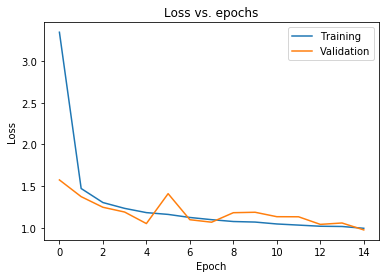

In [17]:
# Plot the learning curves for loss vs epoch for both training and validation sets.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

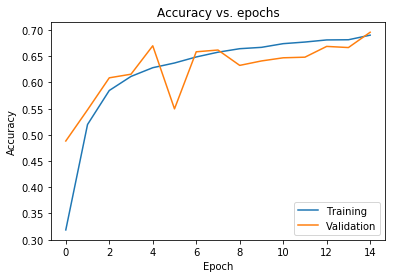

In [18]:
#Plot the learning curves for accuracy vs epoch for both training and validation sets.
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

In [19]:
# Test accuracy
model.evaluate(test_inputs,test_labels,verbose = 2)

26032/1 - 4s - loss: 1.0550 - sparse_categorical_accuracy: 0.6684


[1.108975955439112, 0.6683697]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [20]:
# Create CNN model
def get_CNN_model(input_shape):
    model = Sequential([
        # first conv2D layer with maxpool, dropout and batchnorm
        Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
        MaxPool2D((2,2)),
        Dropout(0.2),
        BatchNormalization(),
        # second conv2D layer with maxpool, dropout and batchnorm
        Conv2D(64,(3,3),activation ='relu'),
        MaxPool2D((2,2)),
        Dropout(0.2),
        BatchNormalization(),
        # third conv2D layer with maxpool, dropout and batchnorm
        Conv2D(128,(3,3),activation ='relu'),
        MaxPool2D((2,2)),
        Dropout(0.2),
        BatchNormalization(),
        # Dense layer
        Flatten(),
        Dense(128,activation='relu'),
        Dense(10,activation='softmax')
    ]
    )
    
    # define optimizer , loss function , and evaluation metric
    opt =  tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    acc = tf.keras.metrics.SparseCategoricalAccuracy()
    
    model.compile(optimizer  = opt , loss = loss,metrics=[acc])
    
    return model

In [21]:
# get new model and print summary
CNN_model = get_CNN_model(train_inputs[0].shape)
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)         

In [22]:
# CNN model Callbacks

def CNN_model_checkpoint_best():
    checkpoint_path = 'CNN_checkpoints_best_only/checkpoint'
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                save_weights_only = True,
                                save_freq  = 'epoch',
                                save_best_only = True,
                                monitor = 'val_sparse_categorical_accuracy'
                                )
    return checkpoint


def CNN_model_checkpoint_every_epoch():
    checkpoint_path = 'CNN_checkpoints_every_epoch/checkpoint_{epoch:03d}' 
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                save_weights_only = True,
                                save_freq  = 'epoch'
                                )
    return checkpoint

In [23]:
# Create Callback object 

callbacks = [CNN_model_checkpoint_best(),CNN_model_checkpoint_every_epoch(),early_stopping()]

In [24]:
# Train model 
history = train_model(CNN_model, train_inputs, train_labels, epochs=30,callbacks = callbacks)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62268/62268 [==============================] - 450s 7ms/sample - loss: 0.8693 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.4802 - val_sparse_categorical_accuracy: 0.8519
Epoch 2/30
62268/62268 [==============================] - 457s 7ms/sample - loss: 0.4689 - sparse_categorical_accuracy: 0.8557 - val_loss: 0.3470 - val_sparse_categorical_accuracy: 0.8970
Epoch 3/30
62268/62268 [==============================] - 448s 7ms/sample - loss: 0.3957 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.3126 - val_sparse_categorical_accuracy: 0.9076
Epoch 4/30
62268/62268 [==============================] - 451s 7ms/sample - loss: 0.3554 - sparse_categorical_accuracy: 0.8914 - val_loss: 0.2803 - val_sparse_categorical_accuracy: 0.9204
Epoch 5/30
62268/62268 [==============================] - 455s 7ms/sample - loss: 0.3268 - sparse_categorical_accuracy: 0.8998 - val_loss: 0.2928 - val_sparse_categorical_accuracy: 0.9166
Epoch 6/30

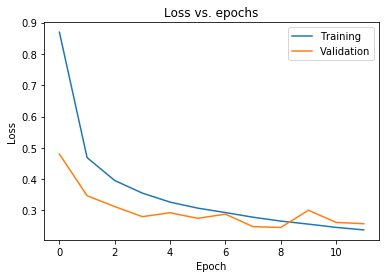

In [25]:
# Plot the learning curves for loss vs epoch for both training and validation sets.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

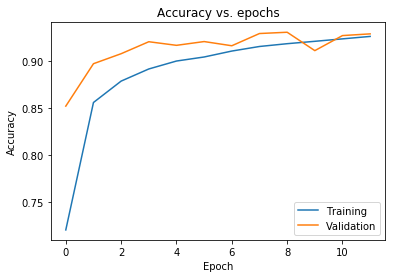

In [26]:
#Plot the learning curves for accuracy vs epoch for both training and validation sets.
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

In [27]:
# Test accuracy
CNN_model.evaluate(test_inputs,test_labels,verbose = 2)

26032/1 - 51s - loss: 0.1643 - sparse_categorical_accuracy: 0.9242


[0.27422525765535727, 0.92417026]

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [28]:
# Load best weight for MLP and CNN model

best_mlp_model = get_MLP_model(train_inputs[0].shape)
best_mlp_model.load_weights('MLP_checkpoints_best_only/checkpoint')

best_cnn_model = get_CNN_model(train_inputs[0].shape)
best_cnn_model.load_weights('CNN_checkpoints_best_only/checkpoint')

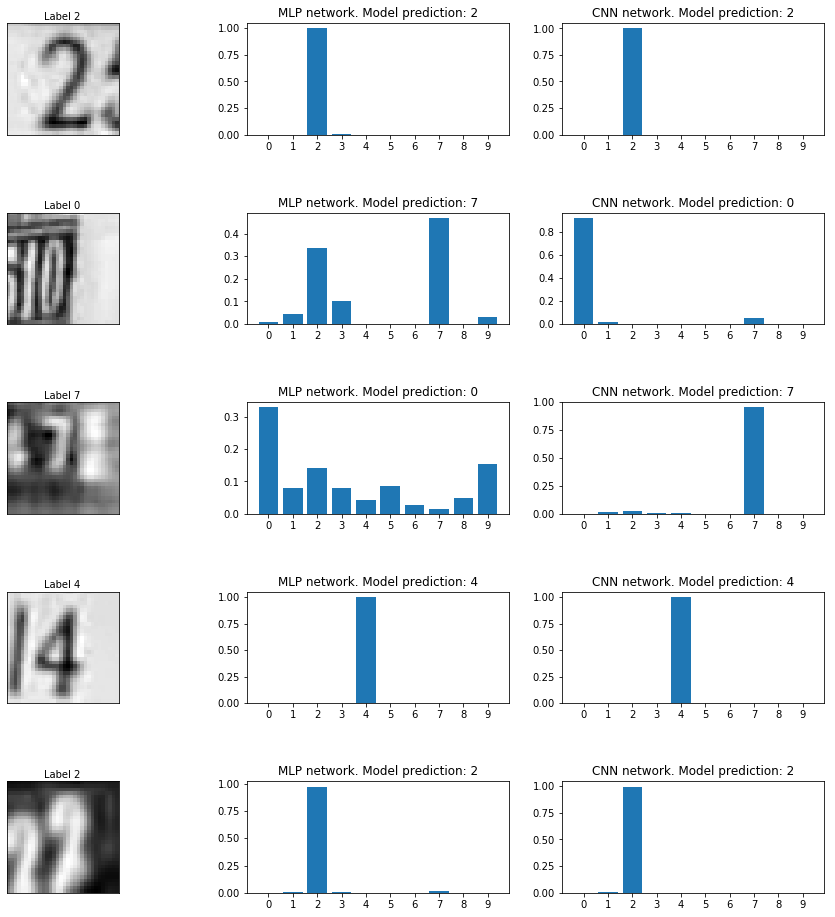

In [32]:
#Select a random  5 sample of images and corresponding labels from test set

rand_5_sample = np.random.permutation(test_inputs.shape[0])[:5]
rand_5_images = test_inputs[rand_5_sample , ...]
rand_5_labels = test_labels[rand_5_sample]


# make prediction of 5 test sample
best_mlp_model_predict = best_mlp_model.predict(rand_5_images)
best_cnn_model_predict = best_cnn_model.predict(rand_5_images)


# Display image with ground truth label alongside with  model’s predictive distribution for both network
row = 5
col = 3

fig, axes = plt.subplots(row, col, figsize=(16, 16))
fig.subplots_adjust(hspace=0.7)

for i,(predict_mlp,predict_cnn,image,label) in enumerate(zip(best_mlp_model_predict,best_cnn_model_predict,rand_5_images,rand_5_labels)):
    # image plot with ground truth label
    axes[i, 0].imshow(np.squeeze(image),cmap = 'gray') # model input require grayscale image
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Label {label}')
    
    # Categorical dittribution of MLP netwotk Prediction
    axes[i, 1].bar(np.arange(len(predict_mlp)), predict_mlp)
    axes[i, 1].set_xticks(np.arange(len(predict_mlp)))
    axes[i, 1].set_title(f"MLP network. Model prediction: {np.argmax(predict_mlp)}")
    
    # Categorical dittribution of CNN netwotk Prediction
    axes[i, 2].bar(np.arange(len(predict_cnn)), predict_cnn)
    axes[i, 2].set_xticks(np.arange(len(predict_cnn)))
    axes[i, 2].set_title(f"CNN network. Model prediction: {np.argmax(predict_cnn)}")
    